In [1]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

from torch.utils.tensorboard import SummaryWriter

In [2]:
print(f"Pytorch Version: {torch.__version__}")
print(torch.__config__.show())

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")

Pytorch Version: 1.13.1+cu117
PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) oneAPI Math Kernel Library Version 2021.4-Product Build 20210904 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_86
  - CuDNN 8.5
  - Magma 2.6.1
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=11.7, CUDNN_VERSION=8.5.0, CXX_COMPILER=/opt/rh/devtoolset-9/root/usr/bin/c++, CXX_FLAGS= -fabi-version=11 -Wno-deprecated -fvisibility-inlines-hidden -DUSE_PTHREADPOOL -fope

In [3]:
train_dataset = datasets.FashionMNIST(
    root = '/media/sambhav/30AC4696AC46568E/datasets',
    train = True,
    transform=transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((.5, ), (.5,))])
)

test_dataset = datasets.FashionMNIST(
    root = '/media/sambhav/30AC4696AC46568E/datasets',
    train = False,
    transform=transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((.5, ), (.5,))])
)

#train_dataset.data.to(DEVICE)
#train_dataset.targets.to(DEVICE)
#test_dataset.data.to(DEVICE)
#test_dataset.targets.to(DEVICE)

torch.Size([1, 28, 28])
cpu


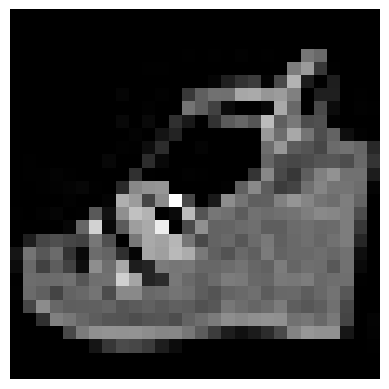

In [4]:
idx = torch.randint(1, len(train_dataset), (1,)).item()
img, label = train_dataset.__getitem__(idx)
plt.axis('off')
plt.imshow(img.squeeze(), cmap = 'gray')
print(img.shape)
print(img.device)

In [5]:
#HYPERPARAMETERS
NUM_EPOCHS = 40 
BATCH_SIZE = 64
NUM_WORKERS = 8

In [6]:
train_loader = DataLoader(
    dataset = train_dataset, 
    batch_size = BATCH_SIZE, 
    shuffle = True, 
    num_workers = NUM_WORKERS)

test_loader = DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = NUM_WORKERS
)

In [7]:
class TinyModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.input = torch.nn.Flatten(start_dim = 1, end_dim = -1)
        self.linear1 = torch.nn.Linear(28 * 28, 1000)
        self.linear2 = torch.nn.Linear(1000, 500)
        self.linear3 = torch.nn.Linear(500, 10)
    
    def forward(self, x):
        x = self.input(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        return x

In [8]:
def train_one_epoch(dataloader, model, criterion, optimizer):
    num_batches = len(dataloader)
    epoch_loss = 0.0
    for batch_idx, (data, targets) in enumerate(dataloader):
        data, targets = data.to(DEVICE), targets.to(DEVICE)

        model.train()
        prediction = model(data) 

        loss = criterion(prediction, targets) 
        epoch_loss += loss.item() / num_batches

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return epoch_loss

In [9]:
def test_one_epoch(dataloader, model, criterion):
    with torch.no_grad():

        num_batches = len(test_loader)
        epoch_loss = 0.0
        correct = 0

        model.eval()
        for batch_idx, (data, targets) in enumerate(dataloader):
            data, targets = data.to(DEVICE), targets.to(DEVICE)
            prediction = model(data)
            predicted_labels = prediction.argmax(1)

            loss = criterion(prediction, targets)
            epoch_loss += loss.item() / num_batches

            correct += (prediction.argmax(1) == targets).int().sum().item() / len(test_dataset)
            accuracy = correct*100

        print(f"Accuracy: {accuracy:>.2f}, Test Loss: {epoch_loss}")
        return epoch_loss, accuracy

In [10]:
tinymodel = TinyModel().to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(tinymodel.parameters(), lr = 1e-3)

In [11]:
writer = SummaryWriter()
for epoch in range(1, NUM_EPOCHS+1):
    train_loss = train_one_epoch(train_loader, tinymodel, criterion, optimizer)
    test_loss, accuracy = test_one_epoch(test_loader, tinymodel, criterion)
    
    writer.add_scalar("Train / Loss", train_loss, epoch)
    writer.add_scalar("Test / Loss", test_loss, epoch)
    writer.add_scalar("Test / Accuracy", accuracy, epoch)

Accuracy: 63.80, Test Loss: 1.1657489690051717
Accuracy: 73.68, Test Loss: 0.9230888123345223
Accuracy: 74.62, Test Loss: 0.9102463338785106
Accuracy: 73.64, Test Loss: 0.9314931414689231
Accuracy: 74.06, Test Loss: 0.9156882546509904
Accuracy: 74.31, Test Loss: 0.9129131128833551
Accuracy: 75.11, Test Loss: 0.898957104629772
Accuracy: 75.42, Test Loss: 0.8840734856143879
Accuracy: 74.74, Test Loss: 0.9033633554057712
Accuracy: 77.75, Test Loss: 0.7851580865443892
Accuracy: 78.72, Test Loss: 0.7583447417635824
Accuracy: 78.53, Test Loss: 0.7590067707429264
Accuracy: 78.53, Test Loss: 0.773053901020888
Accuracy: 80.24, Test Loss: 0.7682157551786699
Accuracy: 79.93, Test Loss: 0.7724615449358699
Accuracy: 78.70, Test Loss: 0.7698991617579365
Accuracy: 81.24, Test Loss: 0.5646802930125764
Accuracy: 81.27, Test Loss: 0.5838429303305922
Accuracy: 80.99, Test Loss: 0.5969329169791215
Accuracy: 81.27, Test Loss: 0.5768860658262946
Accuracy: 80.96, Test Loss: 0.5863389500007508
Accuracy: 81.46